# Double Deep Q-Learning

## The Open AI Lunar Lander environment 

The [OpenAI Gym](https://gym.openai.com/) is a RL platform that provides standardized environments to test and benchmark RL algorithms using Python. It is also possible to extend the platform and register custom environments.

The [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2) (LL) environment requires the agent to control its motion in two dimensions, based on a discrete action space and low-dimensional state observations that include position, orientation, and velocity. At each time step, the environment provides an observation of the new state and a positive or negative reward.  Each episode consists of up to 1,000 time steps. The following diagram shows selected frames from a successful landing after 250 episodes by the agent we will train:

<img src="img/lunar_lander.png" width="700">

More specifically, the agent observes eight aspects of the state, including six continuous and two discrete elements. Based on the observed elements, the agent knows its location, direction, speed of movement, and whether it has (partially) landed. However, it does not know where it should be moving using its available actions or observe the inner state of the environment in the sense of understanding the rules that govern its motion.

At each time step, the agent controls its motion using one of four discrete actions. It can do nothing (and continue on its current path), fire its main engine (to reduce downward motion), or steer to the left or right using the respective orientation engines. There are no fuel limitations.

The goal is to land the agent between two flags on a landing pad at coordinates (0, 0), but landing outside of the pad is possible. The agent accumulates rewards in the range of 100-140 for moving toward the pad, depending on the exact landing spot. However, moving away from the target negates the reward the agent would have gained by moving toward the pad. Ground contact by each leg adds ten points, and using the main engine costs -0.3 points.

An episode terminates if the agent lands or crashes, adding or subtracting 100 points, respectively, or after 1,000 time steps. Solving LL requires achieving a cumulative reward of at least 200 on average over 100 consecutive episodes.

## Deep Q-Learning

Deep Q learning estimates the value of the available actions for a given state using a deep neural network. It was introduced by Deep Mind's [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) (2013), where RL agents learned to play games solely from pixel input.

The Deep Q-Learning algorithm approximates the action-value function q by learning a set of weights  of a multi-layered Deep Q Network (DQN) that maps states to actions so that $$q(s,a,\theta)\approx q^*(s,a)$$

The algorithm applies gradient descent to a loss function defined as the squared difference between the DQN's estimate of the target 
$$y_i=\mathbb{E}[r+\gamma\max_{a^\prime}Q(s^\prime, a^\prime; \theta_{i−1}\mid s,a)]$$ 
and its estimate of the action-value of the current state-action pair  to learn the network parameters:

$$L_i(\theta_i)=\mathbb{E}\left[\left(\overbrace{\underbrace{y_i}_{\text{Q Target}}−\underbrace{Q(s, a; \theta)}_{\text{Current Prediction}}}^{\text{TD Error}}\right)^2 \right]$$

Both the target and the current estimate depend on the set of weights, underlining the distinction from supervised learning where targets are fixed prior to training. 

### Extensions

Several innovations have improved the accuracy and convergence speed of deep Q-Learning, namely:
- **Experience replay** stores a history of state, action, reward, and next state transitions and randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an ε-greedy action. It increases sample efficiency, reduces the autocorrelation of samples, and limits the feedback due to the current weights producing training samples that can lead to local minima or divergence.
- **Slowly-changing target network** weakens the feedback loop from the current network parameters on the neural network weight updates. Also invented by by Deep Mind in [Human-level control through deep reinforcement learning](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) (2015), it use a slowly-changing target network that has the same architecture as the Q-network, but its weights are only updated periodically. The target network generates the predictions of the next state value used to update the Q-Networks estimate of the current state's value.
- **Double deep Q-learning** addresses the bias of deep Q-Learning to overestimate action values because it purposely samples the highest action value. This bias can negatively affect the learning process and the resulting policy if it does not apply uniformly , as shown by Hado van Hasselt in [Deep Reinforcement Learning with Double Q-learning](https://arxiv.org/abs/1509.06461) (2015). To decouple the estimation of action values from the selection of actions, Double Deep Q-Learning (DDQN) uses the weights, of one network to select the best action given the next state, and the weights of another network to provide the corresponding action value estimate.


## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
from collections import deque, namedtuple
from time import time
from random import sample
import numpy as np
from numpy.random import random, randint, seed
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

import gym
from gym import wrappers

In [2]:
sns.set_style('darkgrid', {'axes.grid' : False})

### Result display helper functions

In [3]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:05.2f}'.format(m, s)

In [4]:
def track_results(episode, episode_reward,
                  rewards_ma, rewards_std,
                  episode_steps, episode_time,
                  epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)

    print('{:>4d} | Reward: {:>5.0f} | MA: {:>5.0f} | '
          'Steps: {:>4d} Time: {:>5.2f} | MA: {:>5.2f} | Total: {} | '
          'eps: {:>6.3f}'.format(episode,
                                 episode_reward,
                                 rewards_ma,
                                 episode_steps[-1],
                                 episode_time[-1],
                                 time_ma,
                                 format_time(T),
                                 epsilon))

### Enable virtual display to run from docker container

This is only required if you run this on server that does not have a display.

In [4]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Set up Gym Environment

We will begin by instantiating and extracting key parameters from the LL environment:

In [5]:
env = gym.make('LunarLander-v2')
state_dim = env.observation_space.shape[0]  # number of dimensions in state
n_actions = env.action_space.n  # number of actions
max_episode_steps = env.spec.max_episode_steps  # max number of steps per episode
env.seed(42)

[42]

### Define hyperparameters

The agent's performance is quite sensitive to several hyperparameters. We will start with the discount and learning rates:

In [ ]:
gamma=.99,  # discount factor
learning_rate=5e-5  # learning rate

We will update the target network every 100 time steps, store up to 1 m past episodes in the replay memory, and sample mini-batches of 1,024 from memory to train the agent:

In [14]:
tau=100  # target network update frequency
replay_capacity=int(1e6)
minibatch_size=1024

The ε-greedy policy starts with pure exploration at ε=1, linear decay to 0.05 over 20,000 time steps, and exponential decay thereafter:

In [ ]:
epsilon_start=1.0
epsilon_end=0.05
epsilon_linear_steps=2e4
epsilon_exp_decay=0.99

In [6]:

layers=(256,) * 3  # units per layer

l2_reg=1e-6  # L2 regularization



video_freq=50

## Create Neural Network

We will use [TensorFlow](https://www.tensorflow.org/) to create our Double Deep Q-Network .

In [ ]:
tf.reset_default_graph()

### Dense Layers

The `create_network` function generates the three dense layers that can be trained and/or reused as required by the Q network and its slower-moving target network:

In [7]:
def create_network(s, layers, trainable, reuse, n_actions=4):
    """Generate Q and target network with same structure"""
    for layer, units in enumerate(layers):
        x = tf.layers.dense(inputs=s if layer == 0 else x,
                            units=units,
                            activation=tf.nn.relu,
                            trainable=trainable,
                            reuse=reuse,
                            name='dense_{}'.format(layer))
    return tf.squeeze(tf.layers.dense(inputs=x,
                                      units=n_actions,
                                      trainable=trainable,
                                      reuse=reuse,
                                      name='output'))

### Placeholders

Key elements of the DDQN's computational graph include placeholder variables for the state, action, and reward sequences:

In [8]:
state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to Q network
next_state = tf.placeholder(dtype=tf.float32, shape=[None, state_dim])  # input to target network
action = tf.placeholder(dtype=tf.int32, shape=[None])  # action indices (indices of Q network output)
reward = tf.placeholder(dtype=tf.float32, shape=[None])  # rewards for target computation
not_done = tf.placeholder(dtype=tf.float32, shape=[None])  # indicators for target computation

### Episode Counter

We add a variable to keep track of episodes:

In [ ]:
episode_count = tf.Variable(0.0, trainable=False, name='episode_count')
add_episode = episode_count.assign_add(1)

### Deep Q Networks

We will create two DQNs to predict q values for the current and next state, where we hold the weights for the second network that's fixed when predicting the next state:

In [ ]:
with tf.variable_scope('Q_Network'):
    # Q network applied to current observation
    q_action_values = create_network(state,
                                     layers=layers,
                                     trainable=True,
                                     reuse=False)

    # Q network applied to next_observation
    next_q_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=True))

### Slow-Moving Target Network

In addition, we will create the target network that we update every tau periods:

In [ ]:
with tf.variable_scope('Target_Network', reuse=False):
    target_action_values = tf.stop_gradient(create_network(next_state,
                                                           layers=layers,
                                                           trainable=False,
                                                           reuse=False))

### Collect Variables and Operations

To build TensorFlow's computational graph, we need to collect the relevant variables and operations:

In [ ]:
q_network_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Q_Network')
target_network_variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Target_Network')

# update target network weights
update_target_ops = []
for i, target_variable in enumerate(target_network_variables):
    update_target_op = target_variable.assign(q_network_variables[i])
    update_target_ops.append(update_target_op)
update_target_op = tf.group(*update_target_ops, name='update_target')

### Compute Q-Learning updates

The target, yi, and the predicted q value is computed as follows:

In [ ]:
# Q target calculation 
targets = reward + not_done * gamma * tf.gather_nd(target_action_values, tf.stack(
                (tf.range(minibatch_size), tf.cast(tf.argmax(next_q_action_values, axis=1), tf.int32)), axis=1))


# Estimated Q values for (s,a) from experience replay
predicted_q_value = tf.gather_nd(q_action_values,
                                 tf.stack((tf.range(minibatch_size),
                                           action), axis=1))

### Compute Loss Function

Finally, the TD loss function that's used for stochastic gradient descent is the mean squared error (MSE) between the target and prediction:

In [ ]:
losses = tf.squared_difference(targets, predicted_q_value)
loss = tf.reduce_mean(losses)
loss += tf.add_n([tf.nn.l2_loss(var) for var in q_network_variables if 'bias' not in var.name]) * l2_reg * 0.5

### Tensorboard summaries

To view results in [tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard), we need to define summaries:

In [ ]:
summaries = tf.summary.merge([
    tf.summary.scalar('episode', episode_count),
    tf.summary.scalar('loss', loss),
    tf.summary.scalar('max_q_value', tf.reduce_max(predicted_q_value)),
    tf.summary.histogram('loss_hist', losses),
    tf.summary.histogram('q_values', predicted_q_value)])

### Set optimizer

We'll use the [AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer):

In [ ]:
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss,
                                                          global_step=tf.train.create_global_step())

### Initialize TensorFlow session

In [9]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


## Run Experiment

### Set parameters

In [10]:
experiment = 1
train = True
total_steps, max_episodes = 0, 1000

### Initialize variables

In [16]:
experience = deque(maxlen=replay_capacity)
episode_time, episode_steps, episode_rewards, episode_eps = [], [], [], []

In [14]:
epsilon = epsilon_start
epsilon_linear_step = (epsilon_start - epsilon_end) / epsilon_linear_steps

### Set up directories

In [17]:
experiment_dir = Path('results')
monitor_path = experiment_dir / 'monitor'
checkpoint_dir = experiment_dir / 'checkpoints'
checkpoint_path = checkpoint_dir / 'model'

for path in [checkpoint_path, monitor_path]:
    if not path.exists():
        path.mkdir(exist_ok=True, parents=True)

### Set up Tensorflow Logging

In [12]:
log_path = experiment_dir / 'tensorboard'
summary_writer = tf.summary.FileWriter(logdir=log_path / 'experiment_{}'.format(experiment))

saver = tf.train.Saver()
if not train:
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir.as_posix())
    if latest_checkpoint:
        saver.restore(sess, latest_checkpoint)

### Set up Gym Monitoring

We will also use the built-in wrappers that permit the periodic storing of videos that display the agent's performance:

In [ ]:
env = wrappers.Monitor(env,
                       directory=monitor_path.as_posix(),
                       video_callable=lambda count: count % video_freq == 0,
                      force=True)

### Run Training Loop

In [15]:
for episode in range(max_episodes):
    episode_start = time()
    episode_reward = 0
    episode_eps.append(epsilon)

    # Initial state
    this_observation = env.reset()
    for episode_step in range(max_episode_steps):

        # choose action according to epsilon-greedy policy wrt Q
        if train:
            if random() < epsilon:
                selected_action = randint(n_actions)
            else:
                q_s = sess.run(q_action_values,
                               feed_dict={state: this_observation[None]})
                selected_action = np.argmax(q_s)
        else:
            q_s = sess.run(q_action_values,
                           feed_dict={state: this_observation[None]})
            selected_action = np.argmax(q_s)

        next_observation, step_reward, done, _ = env.step(selected_action)
        episode_reward += step_reward

        if train:
            # add to replay buffer
            experience.append((this_observation,
                               selected_action,
                               step_reward,
                               next_observation,
                               0.0 if done else 1.0))

            # update the target weights
            if total_steps % tau == 0:
                _ = sess.run(update_target_op)

            # update weights using minibatch of (s,a,r,s') samples from experience
            if len(experience) >= minibatch_size:
                minibatch = map(np.array, zip(*sample(experience, minibatch_size)))
                states_batch, action_batch, reward_batch, next_states_batch, done_batch = minibatch

                # do a train_op with required inputs
                feed_dict = {
                    state     : states_batch,
                    action    : action_batch,
                    reward    : reward_batch,
                    next_state: next_states_batch,
                    not_done  : done_batch}
                if total_steps % 100 == 0:
                    summary, global_step, _ = sess.run([summaries, tf.train.get_global_step(), train_op],
                                                       feed_dict=feed_dict)
                    summary_writer.add_summary(summary, global_step)
                else:
                    _ = sess.run([train_op],
                                 feed_dict=feed_dict)

        this_observation = next_observation
        total_steps += 1

        # linearly decay epsilon from epsilon_start to epsilon_end for epsilon_linear_steps
        if total_steps < epsilon_linear_steps:
            epsilon -= epsilon_linear_step
        # then exponentially decay every episode
        elif done:
            epsilon *= epsilon_exp_decay

        if done:
            # Increment episode counter
            episode_, _ = sess.run([episode_count, add_episode])
            if train:
                episode_summary = tf.Summary()
                episode_summary.value.add(simple_value=episode_reward,
                                          node_name='episode_reward',
                                          tag='episode_reward')
                episode_summary.value.add(simple_value=np.mean(episode_rewards[-100:]),
                                          node_name='episode_reward_mavg',
                                          tag='episode_reward_mavg')
                episode_summary.value.add(simple_value=episode_step,
                                          node_name='episode_steps',
                                          tag='episode_steps')
                episode_summary.value.add(simple_value=time() - episode_start,
                                          node_name='episode_duration',
                                          tag='episode_duration')
                summary_writer.add_summary(episode_summary, episode_)
                summary_writer.flush()
            break

    episode_time.append(time() - episode_start)
    episode_steps.append(episode_step)
    episode_rewards.append(episode_reward)
    rewards_ma = np.mean([episode_rewards[-100:]])
    rewards_std = np.std([episode_rewards[-100:]])

    track_results(episode, episode_reward,
                  rewards_ma, rewards_std,
                  episode_steps, episode_time,
                  epsilon)

    if rewards_ma > 200:
        saver.save(sess, checkpoint_path.as_posix())
        break

env.close()

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


   0 | Reward:  -192 | MA:  -192 | Steps:  106 Time:  1.28 | MA:  1.28 | Total: 00:01.28 | eps:  0.995
   1 | Reward:  -194 | MA:  -193 | Steps:   92 Time:  0.03 | MA:  0.65 | Total: 00:01.31 | eps:  0.991
   2 | Reward:  -163 | MA:  -183 | Steps:  121 Time:  0.13 | MA:  0.48 | Total: 00:01.44 | eps:  0.985
   3 | Reward:  -126 | MA:  -169 | Steps:   92 Time:  0.01 | MA:  0.36 | Total: 00:01.45 | eps:  0.980
   4 | Reward:  -176 | MA:  -170 | Steps:  100 Time:  0.01 | MA:  0.29 | Total: 00:01.46 | eps:  0.975
   5 | Reward:  -208 | MA:  -176 | Steps:   87 Time:  0.01 | MA:  0.25 | Total: 00:01.47 | eps:  0.971
   6 | Reward:  -295 | MA:  -193 | Steps:  119 Time:  0.02 | MA:  0.21 | Total: 00:01.49 | eps:  0.966
   7 | Reward:  -140 | MA:  -187 | Steps:   94 Time:  0.01 | MA:  0.19 | Total: 00:01.50 | eps:  0.961
   8 | Reward:  -112 | MA:  -178 | Steps:   70 Time:  0.01 | MA:  0.17 | Total: 00:01.51 | eps:  0.958
   9 | Reward:  -395 | MA:  -200 | Steps:  122 Time:  0.02 | MA:  0.15 | 

  80 | Reward:   -75 | MA:  -126 | Steps:  138 Time:  0.45 | MA:  0.32 | Total: 00:25.56 | eps:  0.596
  81 | Reward:   -51 | MA:  -125 | Steps:  133 Time:  0.48 | MA:  0.32 | Total: 00:26.04 | eps:  0.589
  82 | Reward:   -55 | MA:  -124 | Steps:  106 Time:  0.34 | MA:  0.32 | Total: 00:26.38 | eps:  0.584
  83 | Reward:   -20 | MA:  -123 | Steps:  103 Time:  0.34 | MA:  0.32 | Total: 00:26.72 | eps:  0.579
  84 | Reward:  -113 | MA:  -123 | Steps:  156 Time:  0.55 | MA:  0.32 | Total: 00:27.28 | eps:  0.572
  85 | Reward:   -36 | MA:  -122 | Steps:  122 Time:  0.40 | MA:  0.32 | Total: 00:27.68 | eps:  0.566
  86 | Reward:    -4 | MA:  -120 | Steps:  155 Time:  0.51 | MA:  0.32 | Total: 00:28.19 | eps:  0.559
  87 | Reward:   -40 | MA:  -119 | Steps:  111 Time:  0.41 | MA:  0.33 | Total: 00:28.60 | eps:  0.553
  88 | Reward:   -40 | MA:  -119 | Steps:  162 Time:  0.54 | MA:  0.33 | Total: 00:29.14 | eps:  0.546
  89 | Reward:   -10 | MA:  -117 | Steps:  176 Time:  0.58 | MA:  0.33 | 

 160 | Reward:   186 | MA:    -8 | Steps:  600 Time:  3.30 | MA:  2.38 | Total: 04:15.56 | eps:  0.032
 161 | Reward:    76 | MA:    -6 | Steps:  999 Time:  5.44 | MA:  2.43 | Total: 04:21.00 | eps:  0.031
 162 | Reward:    43 | MA:    -6 | Steps:  999 Time:  5.56 | MA:  2.48 | Total: 04:26.56 | eps:  0.031
 163 | Reward:   174 | MA:    -3 | Steps:  593 Time:  2.95 | MA:  2.51 | Total: 04:29.51 | eps:  0.031
 164 | Reward:    41 | MA:    -2 | Steps:  999 Time:  5.64 | MA:  2.56 | Total: 04:35.14 | eps:  0.030
 165 | Reward:   169 | MA:     2 | Steps:  648 Time:  3.37 | MA:  2.59 | Total: 04:38.51 | eps:  0.030
 166 | Reward:     9 | MA:     3 | Steps:  999 Time:  5.37 | MA:  2.64 | Total: 04:43.88 | eps:  0.030
 167 | Reward:    94 | MA:     4 | Steps:  999 Time:  6.05 | MA:  2.70 | Total: 04:49.93 | eps:  0.029
 168 | Reward:   -20 | MA:     6 | Steps:  999 Time:  5.13 | MA:  2.75 | Total: 04:55.05 | eps:  0.029
 169 | Reward:   -68 | MA:     5 | Steps:  999 Time:  5.15 | MA:  2.79 | 

 240 | Reward:   222 | MA:   126 | Steps:  344 Time:  2.33 | MA:  5.56 | Total: 12:05.10 | eps:  0.014
 241 | Reward:   268 | MA:   128 | Steps:  290 Time:  1.98 | MA:  5.53 | Total: 12:07.09 | eps:  0.014
 242 | Reward:   247 | MA:   129 | Steps:  455 Time:  3.13 | MA:  5.54 | Total: 12:10.22 | eps:  0.014
 243 | Reward:   241 | MA:   130 | Steps:  368 Time:  2.53 | MA:  5.52 | Total: 12:12.74 | eps:  0.014
 244 | Reward:   268 | MA:   131 | Steps:  351 Time:  2.40 | MA:  5.49 | Total: 12:15.14 | eps:  0.014
 245 | Reward:   285 | MA:   134 | Steps:  542 Time:  3.88 | MA:  5.47 | Total: 12:19.02 | eps:  0.013
 246 | Reward:   -64 | MA:   133 | Steps:  379 Time:  2.62 | MA:  5.45 | Total: 12:21.64 | eps:  0.013
 247 | Reward:   228 | MA:   133 | Steps:  464 Time:  3.32 | MA:  5.44 | Total: 12:24.96 | eps:  0.013
 248 | Reward:   237 | MA:   134 | Steps:  346 Time:  2.38 | MA:  5.40 | Total: 12:27.34 | eps:  0.013
 249 | Reward:   275 | MA:   138 | Steps:  493 Time:  3.44 | MA:  5.42 | 

### Store Results

In [17]:
results = pd.DataFrame({'episode': list(range(1, len(episode_steps) + 1)),
                        'steps'  : episode_steps,
                        'rewards': episode_rewards,
                        'time'   : episode_time,
                        'epsilon': episode_eps})

fn = 'results.csv' if train else 'performance.csv'
results.to_csv(experiment_dir / fn, index=False)

In [ ]:
params = dict(gamma=gamma, layers=layers, learning_rate=learning_rate, l2_reg=l2_reg,
              tau=tau, replay_capacity=replay_capacity, minibatch_size=minibatch_size,
              epsilon_start=epsilon_start, epsilon_end=epsilon_end, epsilon_linear_steps=epsilon_linear_steps,
              epsilon_exp_decay=epsilon_exp_decay)

parameters = pd.Series(params).to_frame().reset_index()
parameters.columns = ['parameter', 'value']
parameters.to_csv(experiment_dir / 'parameters.csv', index=False)

### Plot Results

In [7]:
results = pd.read_csv(experiment_dir / 'results.csv').rename(columns=str.capitalize)
results = results.set_index('Episode')
results['MA100'] = results.rolling(window=100, min_periods=25).Rewards.mean()

In [8]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 291 entries, 1 to 291
Data columns (total 5 columns):
Epsilon    291 non-null float64
Rewards    291 non-null float64
Steps      291 non-null int64
Time       291 non-null float64
MA100      267 non-null float64
dtypes: float64(4), int64(1)
memory usage: 13.6 KB


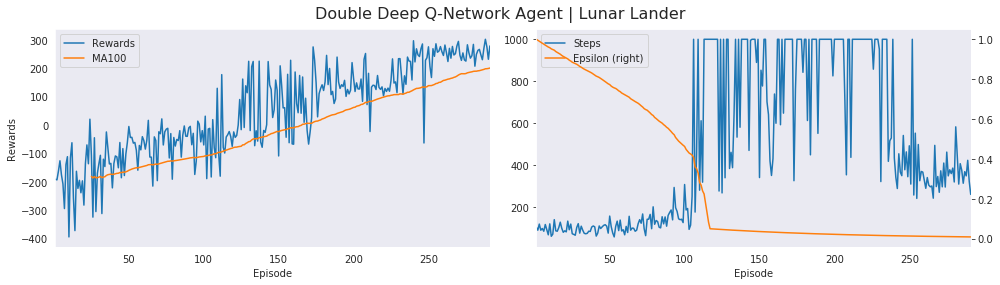

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
results[['Rewards', 'MA100']].plot(ax=axes[0])
axes[0].set_ylabel('Rewards')
results[['Steps', 'Epsilon']].plot(secondary_y='Epsilon', ax=axes[1]);
fig.suptitle('Double Deep Q-Network Agent | Lunar Lander', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('figures/ddqn_lunarlander', dpi=300)